In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from torchsummary import summary

In [5]:
from scipy.optimize import curve_fit
from collections import namedtuple
from collections import OrderedDict


In [6]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [7]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plotxyze, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [9]:
from pymono.cnn_func import  CNN

In [10]:
from pymono.cnn_func import ResNet10

In [11]:
from pymono.cnn_fit import fit_coord, plotfxyz

In [12]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [13]:
from pymono.cnn_eval import evaluate_cnn, cnn_evaluation, single_run, train_cnn
from pymono.cnn_eval import evaluate_cnnx, single_runx, train_cnnx

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [15]:
data_dir = Path(os.environ['MONOLITH_DATA'])

In [16]:
crystal = os.path.join(data_dir,"CsI_3x3_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX")

In [17]:
crystal

'/home/investigator/Data/monolithic_csi/CsI_3x3_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX'

# CsI_3x3_fullwrap_50k_0MHzDC_PTFE_LUT_NX

- CsI crystal assumed cold (100 k hot/MeV)

#### Parameters
- 3x3 SiPMs, thus 16x16 matrix
- 50 k photons per point (CsI, with ~100 k photons/MeV)
- 0MHzDC 
- PTFE wrapping (all sides)
- LUT model
- Nexus simulation
- new data format (x,y,z)



## Define CNNs

In [18]:
def cnn4L(chi=64, ck=[3,3,3,2], cp=[1,1,1,0], ps=[2,2,2,1], lr=[0.01, 0.01, 0.01, 0.01]):
    """
    Define a cNN with 4 layers. 
    input tensor: (N,C,H,W)

    h = H: Height of image.
    w = W: Width of image.
    ck: Size of the convolution kernel for each layer. 
    cp: Padding of the convolution for each layer.
    ps: stride o the MaxPool.
    lr: negative slope of the leaky relu
    
    """
    cnnt =namedtuple('cnnt', 'conv, relu bn, pool')
    #image = torch.randn(1,1,h,w)
   
    CNNT = []
    CNNT.append(cnnt(nn.Conv2d(1, chi, ck[0], padding=cp[0]), nn.LeakyReLU(negative_slope=cp[0]),nn.BatchNorm2d(chi), nn.MaxPool2d(ps[0], ps[0])))
    CNNT.append(cnnt(nn.Conv2d(chi, chi*2, ck[1], padding=cp[1]), nn.LeakyReLU(negative_slope=cp[1]),nn.BatchNorm2d(chi*2), nn.MaxPool2d(ps[1], ps[1])))
    CNNT.append(cnnt(nn.Conv2d(chi*2, chi*4, ck[2], padding=cp[2]), nn.LeakyReLU(negative_slope=cp[2]), nn.BatchNorm2d(chi*4), nn.MaxPool2d(ps[2], ps[2])))
    CNNT.append(cnnt(nn.Conv2d(chi*4, chi*8, ck[3], padding=cp[3]), nn.LeakyReLU(negative_slope=cp[3]), nn.BatchNorm2d(chi*8), nn.MaxPool2d(ps[3], ps[3])))
    fc0 = nn.Linear(chi*8, 3)
    return CNNT, fc0

### model_4L_3222

- CNN consists of 4 layers of convolutions, the first  with kernel of 3x3 and the other three with a kernel of 2x2.
- Each kernel doubles the number of features and halves the number of spatial dimensions.
- Notice that model_4L_3332 reduces spatial dimensions of input kernel to 1x1 if the input kernel has spatial dimensions 16x16 and works also for a smaller kernel (e.g 8x8).

In [19]:
CNNT3222, fc0 = cnn4L(chi=64, ck=[3,2,2,2], cp=[1,1,1,1], ps=[2,2,2,2], lr=[0.01, 0.01, 0.01, 0.01])

In [20]:
cnn_evaluation(torch.randn(1,1,16,16), CNNT3222)

shape of input image = torch.Size([1, 1, 16, 16])
shape of image after convolution 0 = torch.Size([1, 64, 16, 16])
shape of image after pool 0= torch.Size([1, 64, 8, 8])
shape of image after convolution 1 = torch.Size([1, 128, 9, 9])
shape of image after pool 1= torch.Size([1, 128, 4, 4])
shape of image after convolution 2 = torch.Size([1, 256, 5, 5])
shape of image after pool 2= torch.Size([1, 256, 2, 2])
shape of image after convolution 3 = torch.Size([1, 512, 3, 3])
shape of image after pool 3= torch.Size([1, 512, 1, 1])
shape of out image = torch.Size([1, 512, 1, 1])


In [21]:
cnn_evaluation(torch.randn(1,1,8,8), CNNT3222)

shape of input image = torch.Size([1, 1, 8, 8])
shape of image after convolution 0 = torch.Size([1, 64, 8, 8])
shape of image after pool 0= torch.Size([1, 64, 4, 4])
shape of image after convolution 1 = torch.Size([1, 128, 5, 5])
shape of image after pool 1= torch.Size([1, 128, 2, 2])
shape of image after convolution 2 = torch.Size([1, 256, 3, 3])
shape of image after pool 2= torch.Size([1, 256, 1, 1])
shape of image after convolution 3 = torch.Size([1, 512, 2, 2])
shape of image after pool 3= torch.Size([1, 512, 1, 1])
shape of out image = torch.Size([1, 512, 1, 1])


In [25]:
model_4L_3222 = CNN(CNNT3222, fc0, dropout=False).to(device)
print(model_4L_3222)

Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) LeakyReLU(negative_slope=1) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)) LeakyReLU(negative_slope=1) BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)) LeakyReLU(negative_slope=1) BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)) LeakyReLU(negative_slope=1) BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [26]:
summary(model_4L_3222,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
         LeakyReLU-2             [-1, 64, 8, 8]               0
       BatchNorm2d-3             [-1, 64, 8, 8]             128
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 5, 5]          32,896
         LeakyReLU-6            [-1, 128, 5, 5]               0
       BatchNorm2d-7            [-1, 128, 5, 5]             256
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
        LeakyReLU-10            [-1, 256, 3, 3]               0
      BatchNorm2d-11            [-1, 256, 3, 3]             512
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
        LeakyReLU-14            [-1, 51

## Setup

In [27]:
files_list_npy_csv(crystal)

('images',
 'metadata',
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  73,  74,  75,  76,  77,  78,  79,
         80,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100]))

In [28]:
imgs, mdata = select_image_and_lbl(crystal, 3)

Selected files: img = images_4.npy, metdata = metadata_4.csv


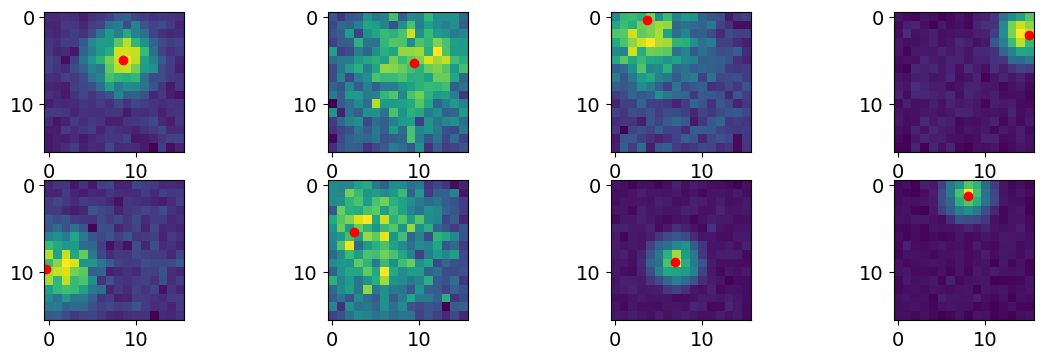

In [29]:
plot_images(imgs, mdata, range(0,8), pixel_size = 3, grid_size=16)

In [30]:
energy = get_energy(crystal, 9)

Selected files: img = images_10.npy, metdata = metadata_10.csv


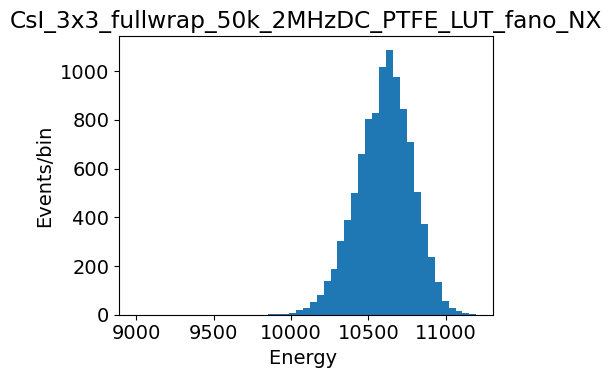

In [31]:
plot_energies2({"CsI_3x3_fullwrap_50k_2MHzDC_PTFE_LUT_fano_NX":energy}, xmin=9000, xmax=max(energy),num_bins = 50)

In [32]:
mean, std, fwhm = mean_rms(energy)
print(f"mean = {mean:.2f} sigma = {100*std:.2f} % FWHM = {100*fwhm:.2f} %")

mean = 10602.78 sigma = 1.68 % FWHM = 3.86 %


## Normalization

In [33]:
means, stds = get_means_stds(dir=crystal)

files in dir: 98
shape -> (10000, 16, 16)
mean img0 =41.3984375
std  img0 =192.47279357910156


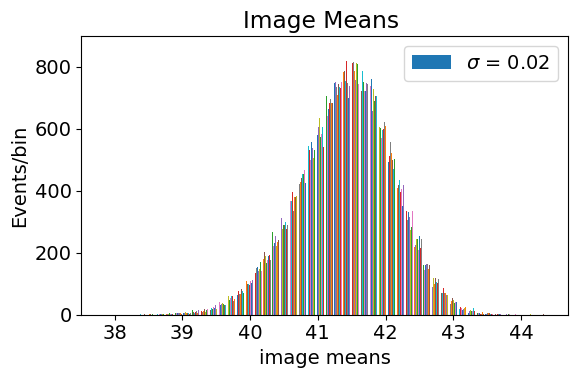

In [34]:
histoplot(means, "image means", vart="Image Means ", num_bins = 50, figsize=(6, 4))

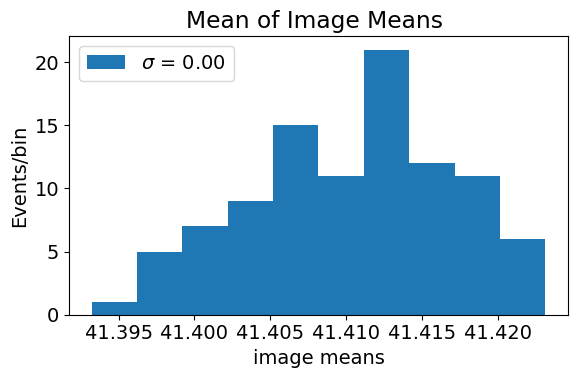

In [35]:
meansx =[np.mean(x) for x in means]
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [36]:
imean = np.mean(meansx)

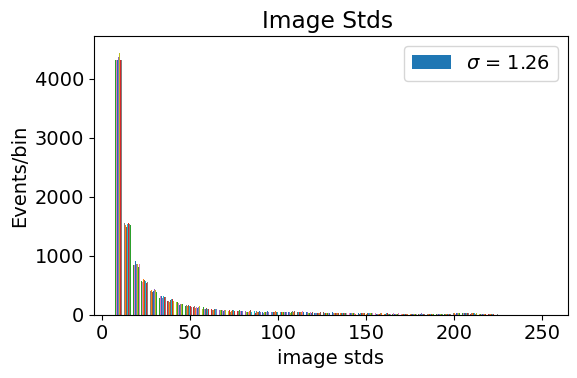

In [37]:
histoplot(stds, "image stds", vart="Image Stds ", num_bins = 50, figsize=(6, 4))

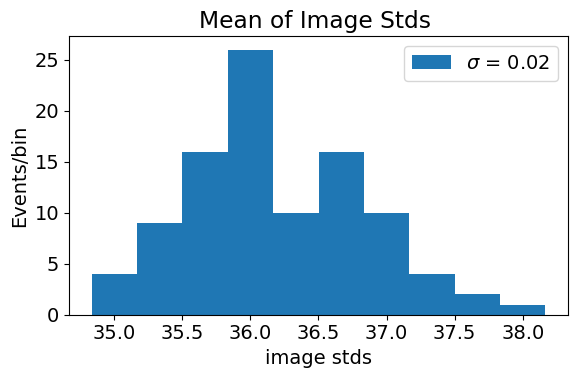

In [38]:
stdsx =[np.std(x) for x in stds]
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [39]:
isigma = np.mean(stdsx)

In [40]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 41.41035461425781, std = 36.19455337524414


### Run with full stats, normalization and dropout,smaller batch size

In [41]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 100  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [42]:
dataset = MonoDataset(crystal, first_file, last_file, norm=True, resize=False, mean=imean, std=isigma,xyze=True)  # No comparison with energy only xyz



Running Monoataset with norm = True, resize=False, xyze=True
Loading files with indexes: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  73
  74  75  76  77  78  79  80  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100]
meta[1:-1] =[-17.736462   5.652053  37.049225]


In [43]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 980000 events
 train size = 686000
 val size = 196000
 test size = 98000
 train indices = range(0, 686000)
 val indices = range(686000, 882000)
 test indices = range(882000, 980000)
686000 training events (70.0%)
196000 validation events (20.0%)
98000 test events (10.0%)


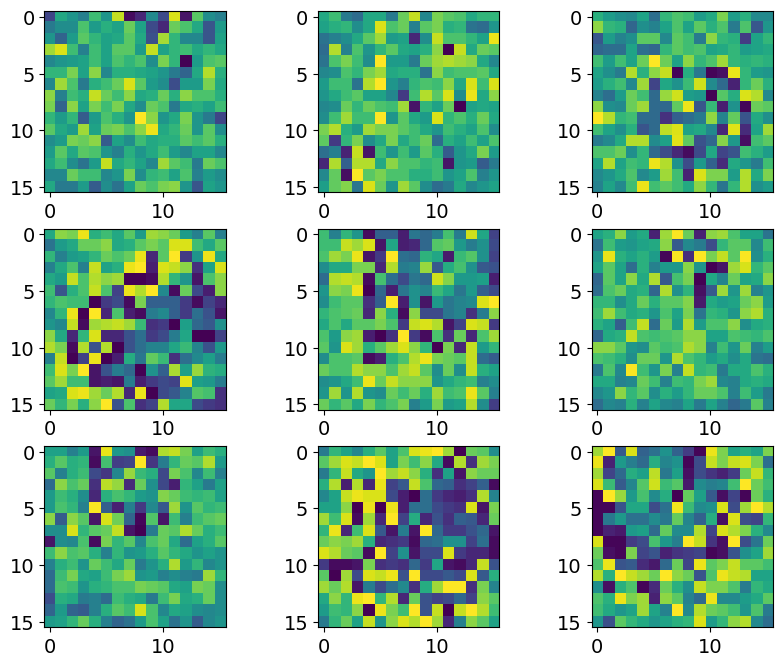

In [44]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

### Model 4L_3222

In [45]:
model_4L_3222 = CNN(CNNT3222, fc0, dropout=True).to(device)
optimizer = optim.Adam(model_4L_3222.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [46]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model_4L_3222, optimizer, device, criterion, 
                                    batch_size, epochs=10, iprnt=2000)

Training with  ->686000 images
size of train loader  ->6860 images
Evaluating with  ->196000 images
size of eval loader  ->1960 images
Running for epochs ->10

EPOCH 0
Train Step 2000/6860, Loss: 9.271931648254395
Train Step 4000/6860, Loss: 6.0161452293396
Train Step 6000/6860, Loss: 5.89844274520874
--- EPOCH 0 AVG TRAIN LOSS: 7.017585598623092
--- EPOCH 0 AVG VAL LOSS: 5.0273665947573525

EPOCH 1
Train Step 2000/6860, Loss: 4.594396114349365
Train Step 4000/6860, Loss: 6.297536373138428
Train Step 6000/6860, Loss: 4.311675548553467
--- EPOCH 1 AVG TRAIN LOSS: 5.45975304080863
--- EPOCH 1 AVG VAL LOSS: 4.712748837227724

EPOCH 2
Train Step 2000/6860, Loss: 4.395046710968018
Train Step 4000/6860, Loss: 5.978396892547607
Train Step 6000/6860, Loss: 5.183176517486572
--- EPOCH 2 AVG TRAIN LOSS: 5.131609366169476
--- EPOCH 2 AVG VAL LOSS: 4.639297391322194

EPOCH 3
Train Step 2000/6860, Loss: 5.997166156768799
Train Step 4000/6860, Loss: 4.631072521209717
Train Step 6000/6860, Loss: 3.61

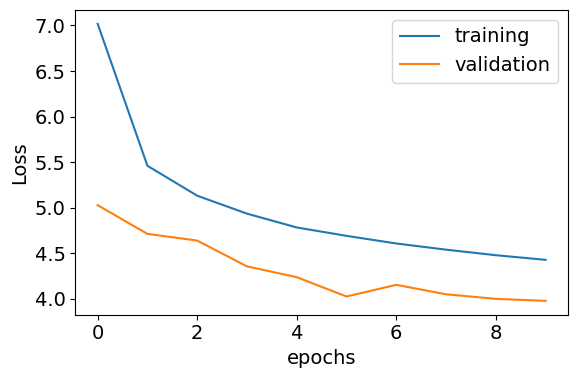

In [47]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [48]:
tdeltas = evaluate_cnn(test_loader, model_4L_3222, device, pixel_size = 3, energy=False)

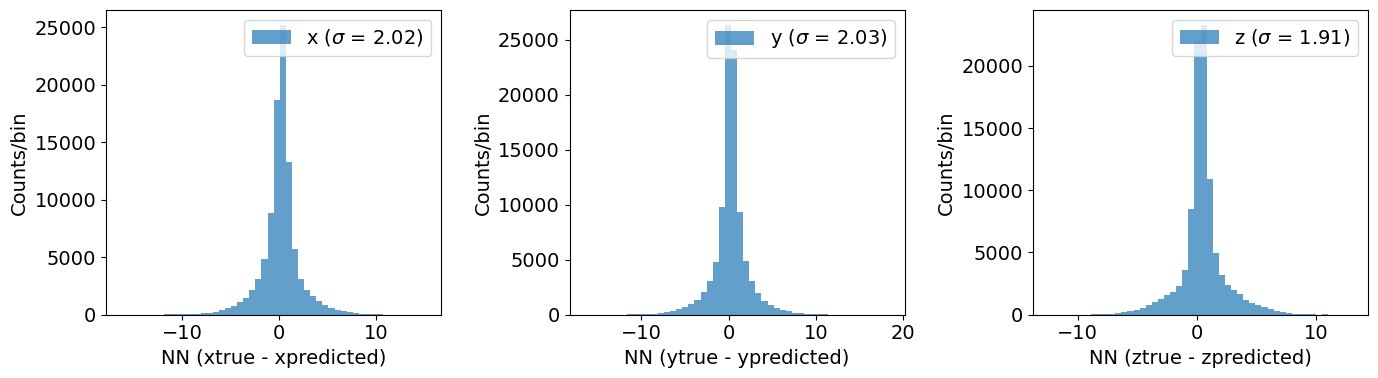

In [49]:
plotxyz(tdeltas, nbins=50)

### Fit the data

In [56]:
#f2gz, f2gx, f2gy = fit_coord(tdeltas, bins=100)
f2gz, f2gx, f2gy = fit_coord(tdeltas.delta_z_NN, tdeltas.delta_x_NN, tdeltas.delta_y_NN, bins=100)

2g fit: mu1 = 0.10, sigma = 0.44, n1  =0.79
2g fit: mu2 = 0.02, sigma = 1.90, n1  =0.21
weighted error: = 0.74
2g fit: mu1 = 0.20, sigma = 0.38, n1  =0.86
2g fit: mu2 = 0.35, sigma = 2.01, n1  =0.14
weighted error: = 0.61
2g fit: mu1 = 0.01, sigma = 0.47, n1  =0.78
2g fit: mu2 = -0.08, sigma = 1.96, n1  =0.22
weighted error: = 0.79


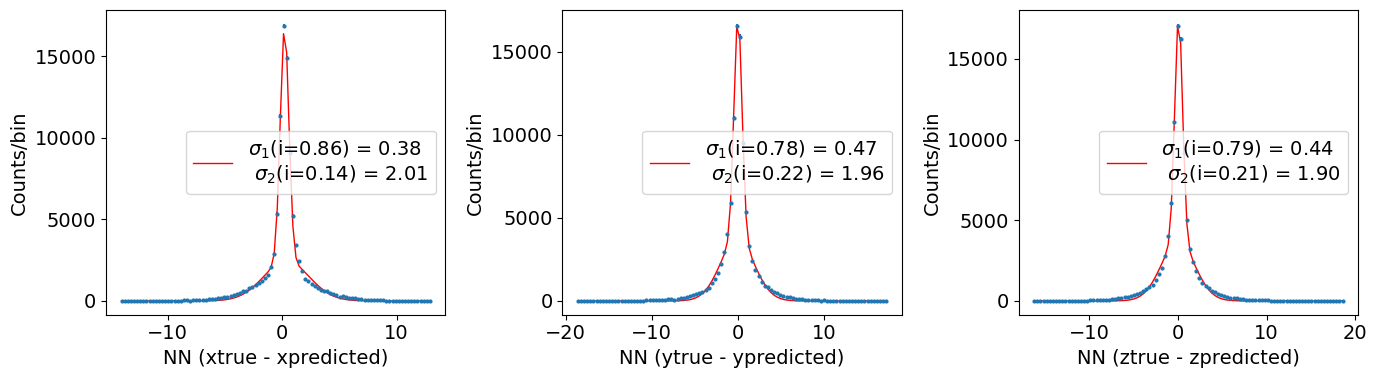

In [57]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## Convoluting 16x16 -> 8x8
- This is done by train_cnnx

In [52]:
train_losses, val_losses = train_cnnx(train_loader, val_loader,
                                    model_4L_3222, optimizer, device, criterion, 
                                    batch_size, epochs=10, iprnt=2000)

Training with  ->686000 images
size of train loader  ->6860 images
Evaluating with  ->196000 images
size of eval loader  ->1960 images
Running for epochs ->10

EPOCH 0
images after conv = torch.Size([100, 1, 8, 8])
images after conv = torch.Size([100, 1, 8, 8])
images after conv = torch.Size([100, 1, 8, 8])
Train Step 2000/6860, Loss: 8.26405143737793
Train Step 4000/6860, Loss: 5.359170913696289
Train Step 6000/6860, Loss: 6.824602127075195
--- EPOCH 0 AVG TRAIN LOSS: 6.434216420678286
--- EPOCH 0 AVG VAL LOSS: 4.4024115218191735

EPOCH 1
images after conv = torch.Size([100, 1, 8, 8])
images after conv = torch.Size([100, 1, 8, 8])
images after conv = torch.Size([100, 1, 8, 8])
Train Step 2000/6860, Loss: 4.345871925354004
Train Step 4000/6860, Loss: 4.4931960105896
Train Step 6000/6860, Loss: 3.783566951751709
--- EPOCH 1 AVG TRAIN LOSS: 4.8444745409940495
--- EPOCH 1 AVG VAL LOSS: 4.238550383095839

EPOCH 2
images after conv = torch.Size([100, 1, 8, 8])
images after conv = torch.Size

In [53]:
tdeltas = evaluate_cnnx(test_loader, model_4L_3222, device)

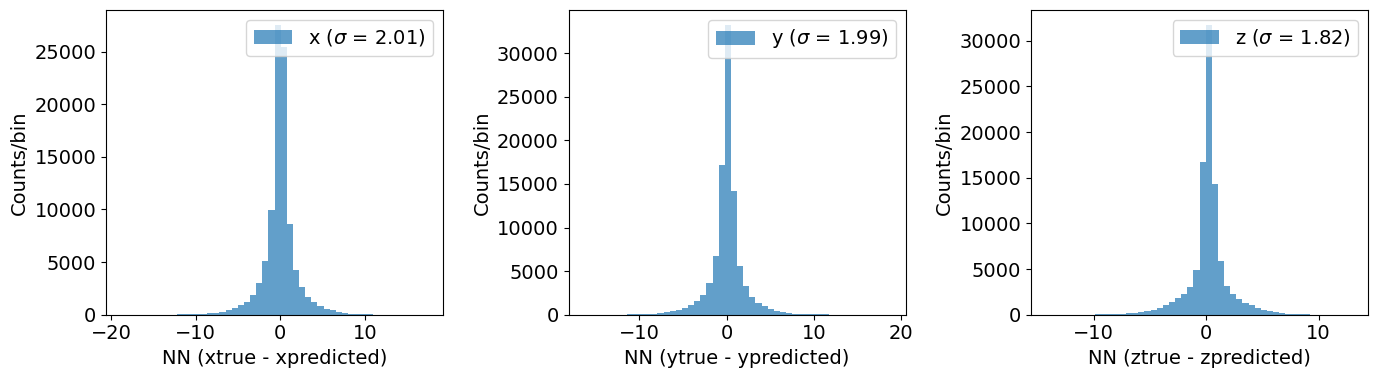

In [54]:
plotxyz(tdeltas, nbins=50)

In [58]:
#f2gz, f2gx, f2gy = fit_coord(tdeltas, bins=100)
f2gz, f2gx, f2gy = fit_coord(tdeltas.delta_z_NN, tdeltas.delta_x_NN, tdeltas.delta_y_NN, bins=100)

2g fit: mu1 = 0.10, sigma = 0.44, n1  =0.79
2g fit: mu2 = 0.02, sigma = 1.90, n1  =0.21
weighted error: = 0.74
2g fit: mu1 = 0.20, sigma = 0.38, n1  =0.86
2g fit: mu2 = 0.35, sigma = 2.01, n1  =0.14
weighted error: = 0.61
2g fit: mu1 = 0.01, sigma = 0.47, n1  =0.78
2g fit: mu2 = -0.08, sigma = 1.96, n1  =0.22
weighted error: = 0.79


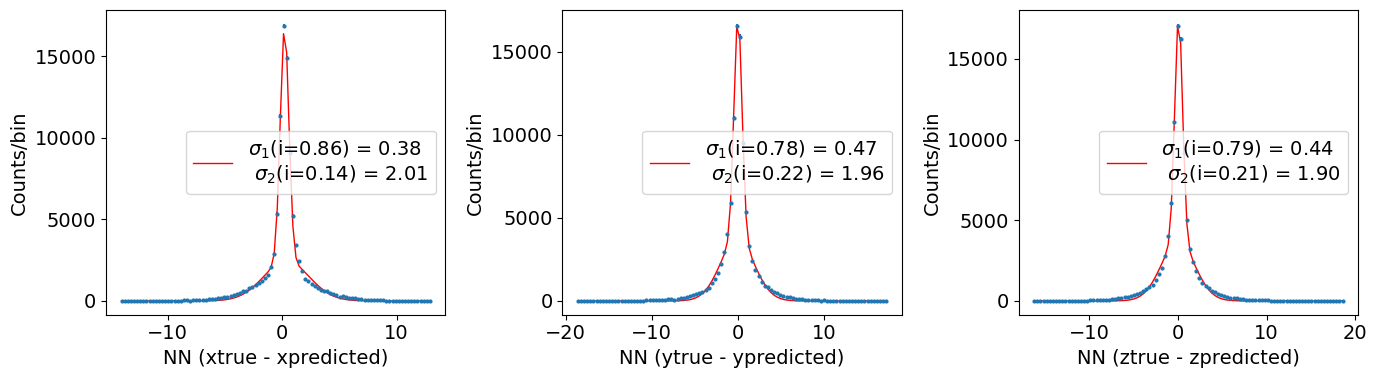

In [59]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))